# Neural Network

In [1]:
# Import the required libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import calendar
from pathlib import Path
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from dateutil.parser import parse

%matplotlib inline

## Using a Single Neuron for Binary Classification

### Step 1 - Import Stock and Social Media data

In [2]:
# Import stock data from .csv file
CEI_df = pd.read_csv(
    Path("../Resources/CEI_data.csv"), 
    delimiter=",",
    index_col = "time",
    parse_dates =True,
    infer_datetime_format =True
    )
# convert datetime
# CEI_df.index = CEI_df.index.astype('datetime64[ns]')
# CEI_df.index.apply(lambda x: x.replace(tzinfo=None))
CEI_df['date'] = CEI_df.index.tz_convert(None).astype(str)
CEI_df['date'] = CEI_df['date'].str.slice(0, 10)
CEI_df.head()

,open,high,low,close,volume,date
time,,,,,,
2021-08-02 00:00:00-04:00,0.4550,0.4550,0.4424,0.445000,7345080,2021-08-02
2021-08-03 00:00:00-04:00,0.4500,0.4650,0.4350,0.457000,9595956,2021-08-03
2021-08-04 00:00:00-04:00,0.4466,0.5000,0.4425,0.497900,42042789,2021-08-04
2021-08-05 00:00:00-04:00,0.4835,0.5191,0.4661,0.474500,35832915,2021-08-05
2021-08-06 00:00:00-04:00,0.4747,0.4760,0.4555,0.460001,10307699,2021-08-06


In [3]:
# Import social media data from .csv file
SM_df = pd.read_csv(
    Path("../reddit_resources/reddit_data.csv"), 
    delimiter=",",
    index_col = "date",
    parse_dates =True,
    infer_datetime_format =True
    )
# Convert datetime
SM_df['date'] = SM_df.index.astype(str)
SM_df['date'] = SM_df['date'].str.slice(0, 10)
SM_df

,title,selftext,score,num_comments,date
date,,,,,
2021-10-02 01:43:23+00:00,"I have no DD. It’s a cheap price, the stock ha...",NaN,1,0,2021-10-02
2021-10-02 01:08:40+00:00,Who is in PED? It is an energy stock! I am in ...,\nToday it had a run. It is an energy stock. H...,1,0,2021-10-02
2021-10-01 20:45:15+00:00,"WHO IS KNOWN FOR CARBON CAPTURE,OH YES. $CEI",NaN,1,0,2021-10-01
2021-10-01 19:21:32+00:00,$PROG - The Next Big Short Squeeze Candidate,"Alright retards, I can't believe I happened up...",1,0,2021-10-01
2021-10-01 18:26:46+00:00,CEI 100% PORT YOLO GAIN HODL TILL 10$+ then 20$,NaN,1,0,2021-10-01
...,...,...,...,...,...
2018-09-24 21:10:24+00:00,CEI too the moon,100%+ returns today what do you guys think?\n\...,1,0,2018-09-24
2018-02-28 20:04:11+00:00,The cheapest thing on Robinhood currently is [...,[removed],21,37,2018-02-28
2017-11-22 16:34:32+00:00,BUY CEI U WILL 9X TIMES INCREASE UR MONEY$$$ h...,[removed],1,0,2017-11-22


In [4]:
# Group the thread and count / sum value by date
grouped_df = SM_df.groupby(SM_df['date']) 
NewSM_df = grouped_df[['score', 'num_comments']].agg('sum')
NewSM_df['thread_volume'] = grouped_df.size()
NewSM_df

,score,num_comments,thread_volume
date,,,
2017-10-06,7,13,1
2017-11-21,1,0,1
2017-11-22,1,0,1
2018-02-28,21,37,1
2018-09-24,1,0,1
...,...,...,...
2021-09-28,30,62,30
2021-09-29,54,119,53
2021-09-30,20,248,20


Text(0.5, 1.0, 'Reddit Thread Volume')

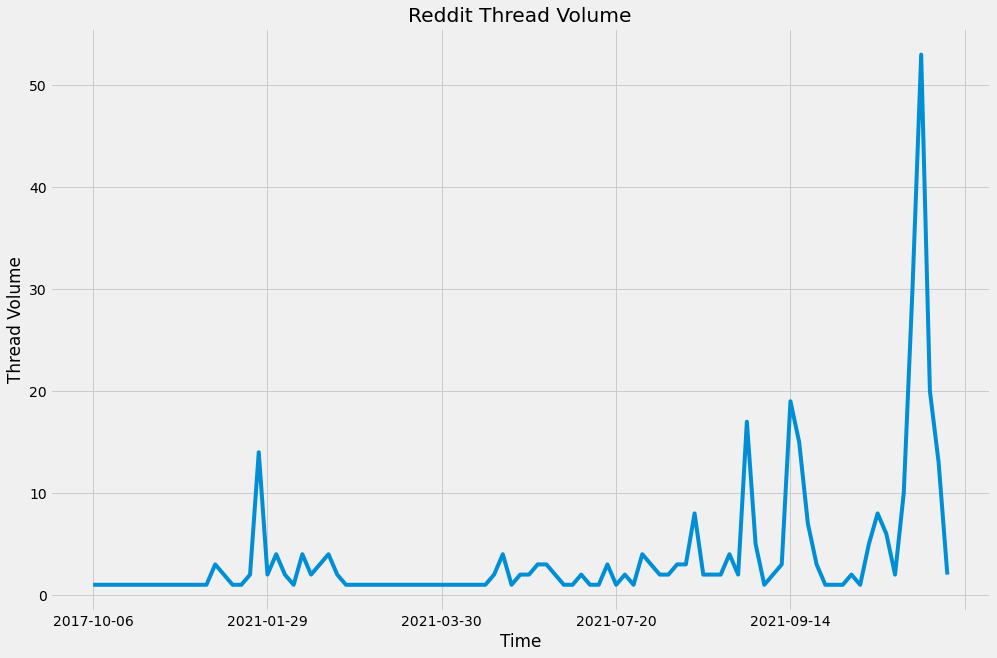

In [5]:
# Evalulate frequency of Reddit Thread each day
matplotlib.style.use('fivethirtyeight')
NewSM_df['thread_volume'].plot(figsize=(15, 10))
plt.xlabel("Time")
plt.ylabel("Thread Volume") 
plt.title("Reddit Thread Volume")

In [6]:
# Merge stock and social media dataframe
df = pd.merge(CEI_df, NewSM_df, how="left", on=['date'])
df = df.fillna(0)
df = df.set_index('date')
df

,open,high,low,close,volume,score,num_comments,thread_volume
date,,,,,,,,
2021-08-02,0.4550,0.4550,0.4424,0.445000,7345080,0.0,0.0,0.0
2021-08-03,0.4500,0.4650,0.4350,0.457000,9595956,0.0,0.0,0.0
2021-08-04,0.4466,0.5000,0.4425,0.497900,42042789,0.0,0.0,0.0
2021-08-05,0.4835,0.5191,0.4661,0.474500,35832915,0.0,0.0,0.0
2021-08-06,0.4747,0.4760,0.4555,0.460001,10307699,0.0,0.0,0.0
2021-08-09,0.4720,0.4851,0.4608,0.480200,18382066,0.0,0.0,0.0
2021-08-10,0.4831,0.4875,0.4650,0.479500,8611522,0.0,0.0,0.0
2021-08-11,0.4700,0.4725,0.4600,0.468300,7732846,0.0,0.0,0.0
2021-08-12,0.4697,0.4700,0.4401,0.447500,7738982,0.0,0.0,0.0


In [7]:
# Export dataframe to .csv file
df.to_csv(Path('../Resources/CEIandReddit_data.csv'))

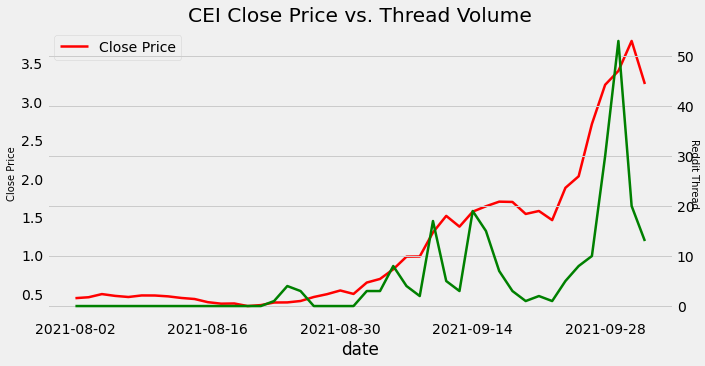

In [8]:
# Plot graph of Close Price vs. Thread count
fig, ax = plt.subplots()
df['close'].plot(figsize=(10, 5), ax=ax, color='r', linewidth=2.5, label='Close Price')
df['thread_volume'].plot(secondary_y=True, ax=ax, color='g', linewidth=2.5, label='Thread Volume')
ax.set_ylabel('Close Price', fontsize=10);

plt.xlabel('Date', fontsize=10)
plt.ylabel('Reddit Thread', fontsize=10, rotation=-90)
plt.title('CEI Close Price vs. Thread Volume')
ax.legend()

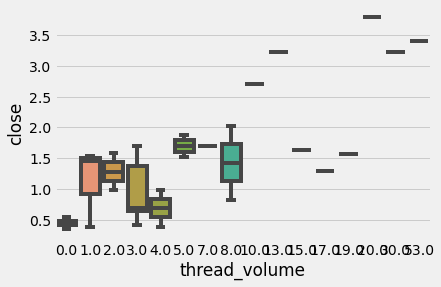

In [9]:
sns.boxplot(x=df['thread_volume'],y=df['close'],data=df)
plt.show()

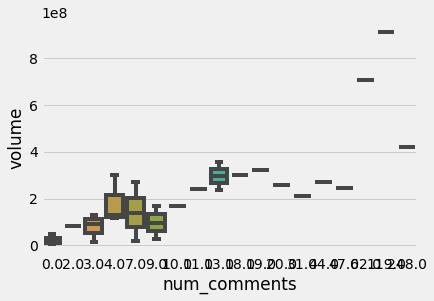

In [10]:
sns.boxplot(x=df['num_comments'],y=df['volume'],data=df)
plt.show()

In [11]:
# Generate input features
cols_to_calc_change = ['open','high','low','volume','close']
windows_back_to_calc = [1]

for days in windows_back_to_calc:
    for col in cols_to_calc_change:    
        Change_ndayago = ['Null']*days
        for i in range(len(df)-days):
            Change_ndayago.append(df[f'{col}'][i+days]/df[f'{col}'][i+days-1])
        df[f'{col}Change'] = Change_ndayago

df.replace(["NaN", 'Null'], np.nan, inplace = True)
df = df.dropna()
df.head(30)

,open,high,low,close,volume,score,num_comments,thread_volume,openChange,highChange,lowChange,volumeChange,closeChange
date,,,,,,,,,,,,,
2021-08-03,0.4500,0.4650,0.4350,0.457000,9595956,0.0,0.0,0.0,0.989011,1.021978,0.983273,1.306447,1.026966
2021-08-04,0.4466,0.5000,0.4425,0.497900,42042789,0.0,0.0,0.0,0.992444,1.075269,1.017241,4.381303,1.089497
2021-08-05,0.4835,0.5191,0.4661,0.474500,35832915,0.0,0.0,0.0,1.082624,1.038200,1.053333,0.852296,0.953003
2021-08-06,0.4747,0.4760,0.4555,0.460001,10307699,0.0,0.0,0.0,0.981799,0.916972,0.977258,0.287660,0.969444
2021-08-09,0.4720,0.4851,0.4608,0.480200,18382066,0.0,0.0,0.0,0.994312,1.019118,1.011636,1.783334,1.043911
2021-08-10,0.4831,0.4875,0.4650,0.479500,8611522,0.0,0.0,0.0,1.023517,1.004947,1.009115,0.468474,0.998542
2021-08-11,0.4700,0.4725,0.4600,0.468300,7732846,0.0,0.0,0.0,0.972883,0.969231,0.989247,0.897965,0.976642
2021-08-12,0.4697,0.4700,0.4401,0.447500,7738982,0.0,0.0,0.0,0.999362,0.994709,0.956739,1.000793,0.955584
2021-08-13,0.4495,0.4495,0.4320,0.433949,8580468,0.0,0.0,0.0,0.956994,0.956383,0.981595,1.108733,0.969718


### Step 2 - Encoded Data

In [12]:
# Split target column from dataset
y = df['close']
X = df.drop(['open','high','low','volume','close'],axis=1)

# Set Index
# X = X.set_index(df.loc['date'])

# Binary encoding using Pandas (multiple columns) for Social Media Data
# X = pd.get_dummies(X)

X.tail()

,score,num_comments,thread_volume,openChange,highChange,lowChange,volumeChange,closeChange
date,,,,,,,,
2021-09-27,10.0,19.0,10.0,1.234973,1.222707,1.220994,1.068972,1.334975
2021-09-28,30.0,62.0,30.0,1.274336,1.228571,1.185520,2.208768,1.188192
2021-09-29,54.0,119.0,53.0,1.062500,1.409884,1.103053,1.290560,1.055932
2021-09-30,20.0,248.0,20.0,1.349673,0.901031,1.190311,0.458763,1.114673
2021-10-01,13.0,4.0,13.0,0.845036,0.810069,0.831395,0.717578,0.852243


### Step 3 - Scaling Data

In [13]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Creating the scaler instance
scaler = StandardScaler()

# Fitting the scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4 - Neural Network Model Creation

#### Add the layers of Neural Network

In [14]:
# Create a sequential model
neuron = Sequential()

# First layer of Neural Network
number_inputs = 8
number_hidden_nodes = 5

neuron.add(Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))

# Create the second hidden layer
# number_hidden_nodes2 = 2

# neuron.add(Dense(units=number_hidden_nodes2, activation="relu"))

# Output layer
output_nodes = 1

neuron.add(Dense(units=output_nodes, activation="tanh"))

# Model summary
neuron.summary()

# Compile the model 
## neuron.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Set the parameters as mean_squared_error, adam, and mse.
neuron.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 45        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model
# The validation split parameter splits the data into testing and training sets.
model = neuron.fit(X, y, validation_split=0.2, epochs=500, verbose=0)

#### Evaluate the Model

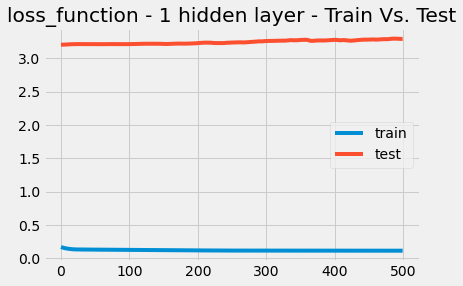

In [16]:
# Plotting the Loss Function and Accuracy
# Create a DataFrame with the history dictionary
# df = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

# Plot the loss
# df.plot(y="loss")

plt.plot(model.history["loss"])
plt.plot(model.history["val_loss"])
plt.title("loss_function - 1 hidden layer - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

In [17]:
# Evaluate the model using the training data
model_loss, model_accuracy = neuron.evaluate(X_train_scaled, y_train, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


1/1 - 0s - loss: 1.1179 - mse: 1.1179
Loss: 1.117943286895752, Accuracy: 1.117943286895752


In [18]:
# Evaluate the model using the testing data
model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 0s - loss: 0.9047 - mse: 0.9047
Loss: 0.9047059416770935, Accuracy: 0.9047059416770935


### Step 5 - Prediction

In [19]:
# Making predictions
predictions = neuron.predict(X_test_scaled)
results = pd.DataFrame({"predictions": predictions.ravel(), "actual": y_test.ravel()})
results.head(10)


,predictions,actual
0,0.490131,0.460001
1,0.183149,0.474500
2,0.828552,0.984900
3,0.998953,3.400100
4,0.303192,0.460000
5,0.979542,1.640000
6,0.859834,0.694900
7,0.469688,1.879900
8,0.474654,1.696200
9,0.295858,0.544800


Text(0.5, 1.0, 'Stock Price Prediction')

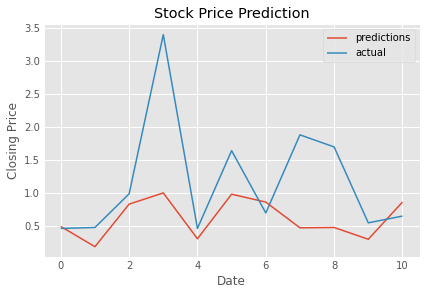

In [20]:
# Plot the CEI stock closing price Actual vs. Prediction
matplotlib.style.use('ggplot')
results.plot(linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Prediction")

In [13]:
# Export dataframe to .csv file

df.to_csv(Path('../Resources/CEIandReddit_data.csv'))